In [8]:
from utils import *
from models import *
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import textwrap


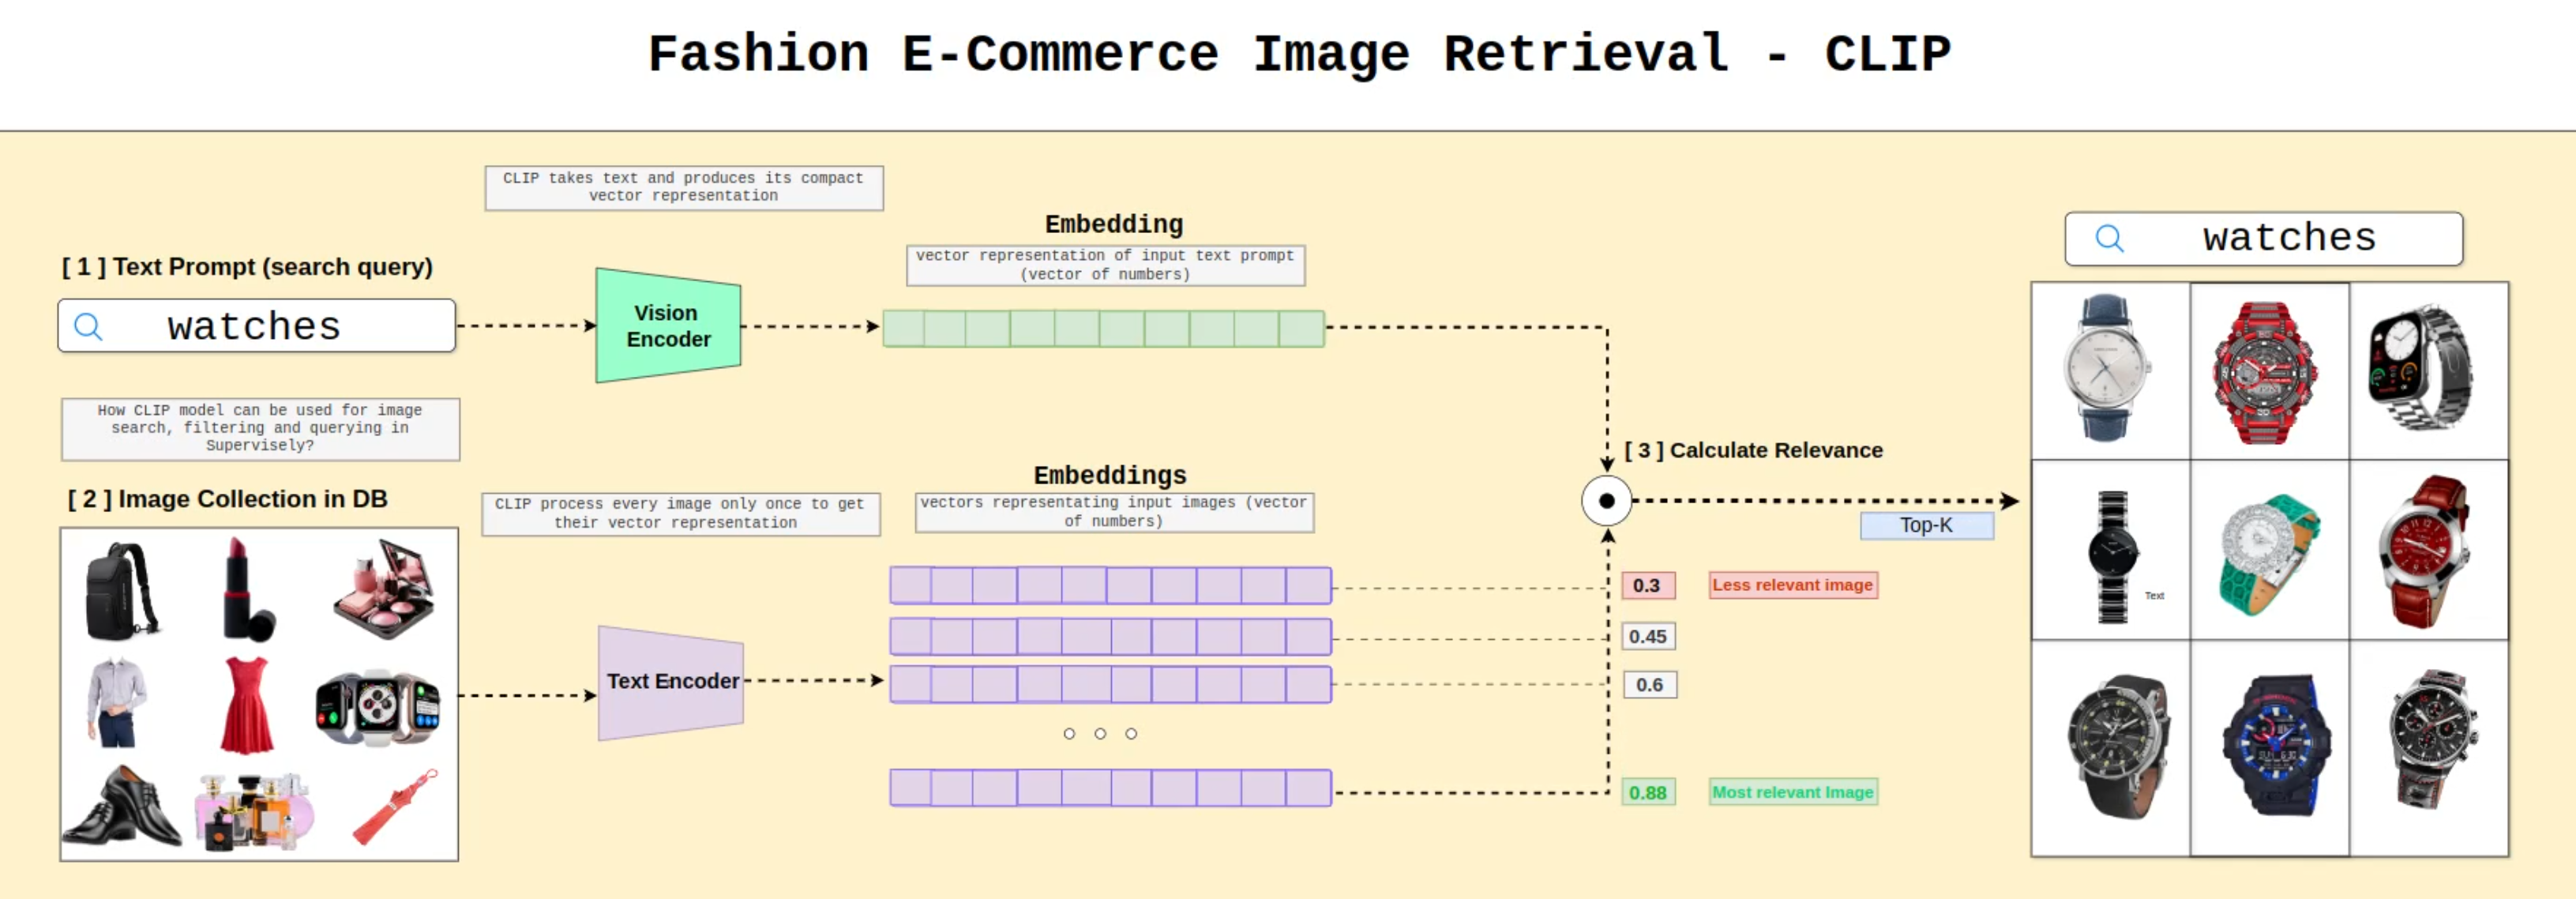

### Load the clip trained weights

In [3]:
model_c = CLIP(
    image_embedding_dim=2048,
    text_embedding_dim=1024,
    projection_dim=512
).to('mps')

state_dict = torch.load("clip.pt")
model_c.load_state_dict(state_dict)

<All keys matched successfully>

### Load the saved image embeddings of our dataset

In [4]:
image_embeddings = torch.load("image_embeddings.pt")
image_embeddings.shape

torch.Size([2872, 512])

### Define the inference function and read our description file

In [29]:
@torch.inference_mode()
def inference(model_clip,query: str, df: pd.DataFrame, n_top_images: int=5, device='mps'):

  query_tokenized = tokenizer([query], padding=True, truncation=True, max_length=200)

  tokens, attention_mask = query_tokenized['input_ids'], query_tokenized['attention_mask']
  tokens, attention_mask = torch.tensor(tokens).to(device), torch.tensor(attention_mask).to(device)

  query_embedding = model_clip.text_projection(model_clip.text_encoder(tokens, attention_mask)) # 1, projection_dim

  logits = image_embeddings @ query_embedding.T 
  top_n_indices = torch.topk(logits.squeeze(), n_top_images).indices.tolist()
  top_image_paths = df.iloc[top_n_indices]['image_path'].to_list()
  top_image_captions = df.iloc[top_n_indices]['caption'].to_list()

  fig, axes = plt.subplots(nrows=3, ncols=math.ceil(n_top_images//3), figsize=(20, 8))
  for ax, img_path, caption in zip(axes.flatten(), top_image_paths, top_image_captions):
      img = Image.open(img_path)
      img = img.resize((300, 300))
      img = mpimg.pil_to_array(img)
      ax.imshow(img)
      # ax.set_title(caption)
      ax.axis('off')

  plt.tight_layout()
  plt.show()


# Load the dictionary from the JSON file
with open("upper_garment_description.json", 'r') as file:
    upper_garment_description = json.load(file)

df = pd.DataFrame(list(upper_garment_description.items()), columns=["image_path", "caption"])
df

image_path  \
0     datasets/fashion_dataset/train/images/image_10...   
1     datasets/fashion_dataset/train/images/image_10...   
2     datasets/fashion_dataset/train/images/image_10...   
3     datasets/fashion_dataset/train/images/image_10...   
4     datasets/fashion_dataset/train/images/image_10...   
...                                                 ...   
3251  datasets/fashion_dataset/train/images/image_30...   
3252  datasets/fashion_dataset/train/images/image_30...   
3253  datasets/fashion_dataset/train/images/image_30...   
3254  datasets/fashion_dataset/train/images/image_30...   
3255  datasets/fashion_dataset/train/images/image_30...   

                                                caption  
0     {'upper': 'The image showcases a cozy, oversiz...  
1     {'upper': 'The image features a light blue, lo...  
2     {'upper': 'The garment in the image is a woman...  
3     {'upper': 'The garment in the image is a women...  
4     {'upper': 'The image depicts a person wearing ...  
...                                                 ...  
3251  {'upper': 'The clothing item visible is a clas...  
3252  {'upper': 'This image showcases a form-fitting...  
3253  {'upper': 'The image showcases a sleeveless wo...  
3254  {'upper': 'The garment is a women's experiment...  
3255                                                 {}  

[3256 rows x 2 columns]

# Inference
1. We will pass an Image and using a VLM model (Gemini Flash Multimodal) we will generate textual description.
2. Embedding will be created by our first by a pretrained sentence transformer and then by CLIP to bring it down to a lower dimension.
3. We compute similarity with our image embeddings and get top_n relevant images.

In [ ]:
def vlm_text(image_path):

    # print("Processing:", image_path)
    detection = detect_clothing(image_path, model_yolo, labels, upper, lower)
    
    for j, detect in enumerate(detection):
        if detect['category'] == 'upper':
            try:
                return process_image(detect['cropped_image'])
            except:
                return 'Exhaustion error'
        else:
            return 'None detected'

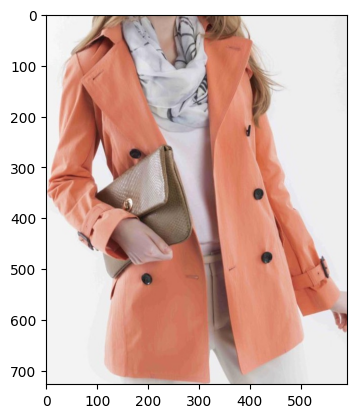

The image showcases a women's double-breasted trench coat in a light coral or
peach color. The coat has a classic, structured silhouette, falling straight to
the mid-thigh with a slight A-line flare. It's likely made of a lightweight
woven fabric, potentially a cotton blend, giving it a smooth, matte texture with
minimal sheen.  The dominant color is the soft coral of the coat itself,
complemented by the black buttons and the off-white hues of the top and pants
underneath, with the neutral tones of the handbag. The coat features traditional
design elements like a notched lapel, a belted sleeve detail, and a double
button-front closure. It’s a versatile piece, suitable for various occasions,
from casual outings to more semi-formal events, depending on layering choices.
It appears ideal for spring and early fall, given the lighter fabric. The
ensemble is finished with a light scarf featuring black line patterns and a
textured, neutral-toned clutch adding a touch of elegance. There are no

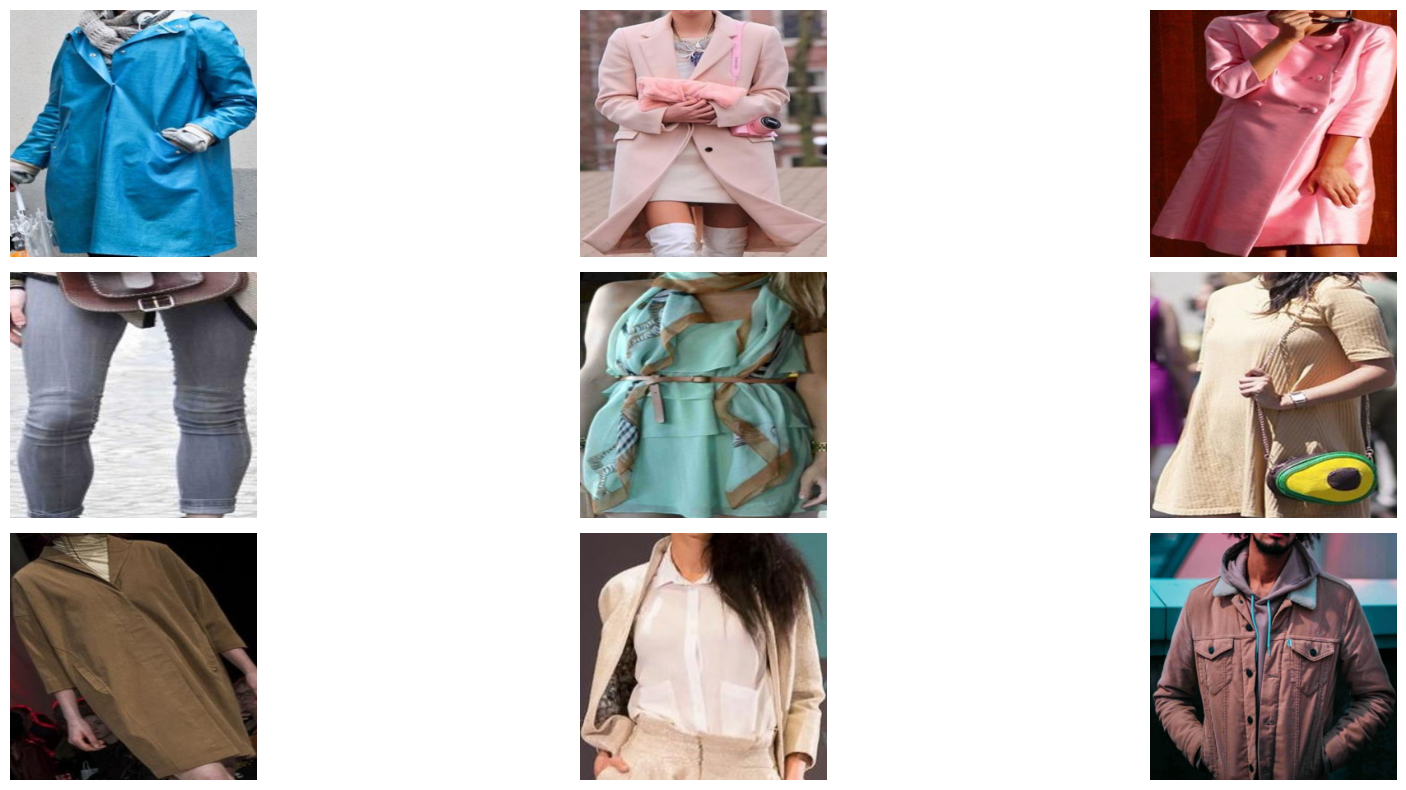

In [15]:
j = 220

imgss = cv2.imread(df['image_path'][j])
imgss = cv2.cvtColor(imgss,cv2.COLOR_BGR2RGB)
plt.imshow(imgss)
plt.show()

# Assuming `df['caption'][j]` is the long text
long_text = vlm_text(df['image_path'][j])

# Wrap the text to a specified width (e.g., 80 characters per line)
wrapped_text = textwrap.fill(long_text, width=80)

# Print the wrapped text
print(wrapped_text)

inference(model_c,query=long_text, df=df, n_top_images=9)


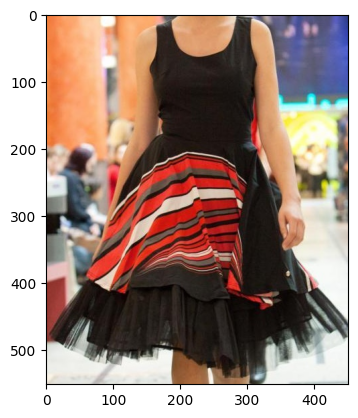

The image features a sleeveless, woman's dress designed with a unique silhouette
and a mix of materials. The top portion of the dress is a simple, fitted black
bodice, likely made of a smooth, matte fabric like cotton or jersey. A flared,
A-line skirt extends from the bodice, distinguished by a bold horizontal striped
pattern in white, red, and grey, creating a dynamic contrast against the black.
A playful, tiered black tulle layer beneath the striped skirt adds volume and a
contrasting texture with a semi-transparent quality. The overall shape is
feminine and slightly retro, with a defined waist and a full, flowing skirt.
This combination of structured and flowy elements makes the dress suitable for a
range of occasions, from casual gatherings to semi-formal events. There are no
visible patterns on the bodice other than the color black, whereas the skirt and
the tulle at the bottom have layered horizontal pattern. The primary colors are
black, red, and white, which makes it suitable f

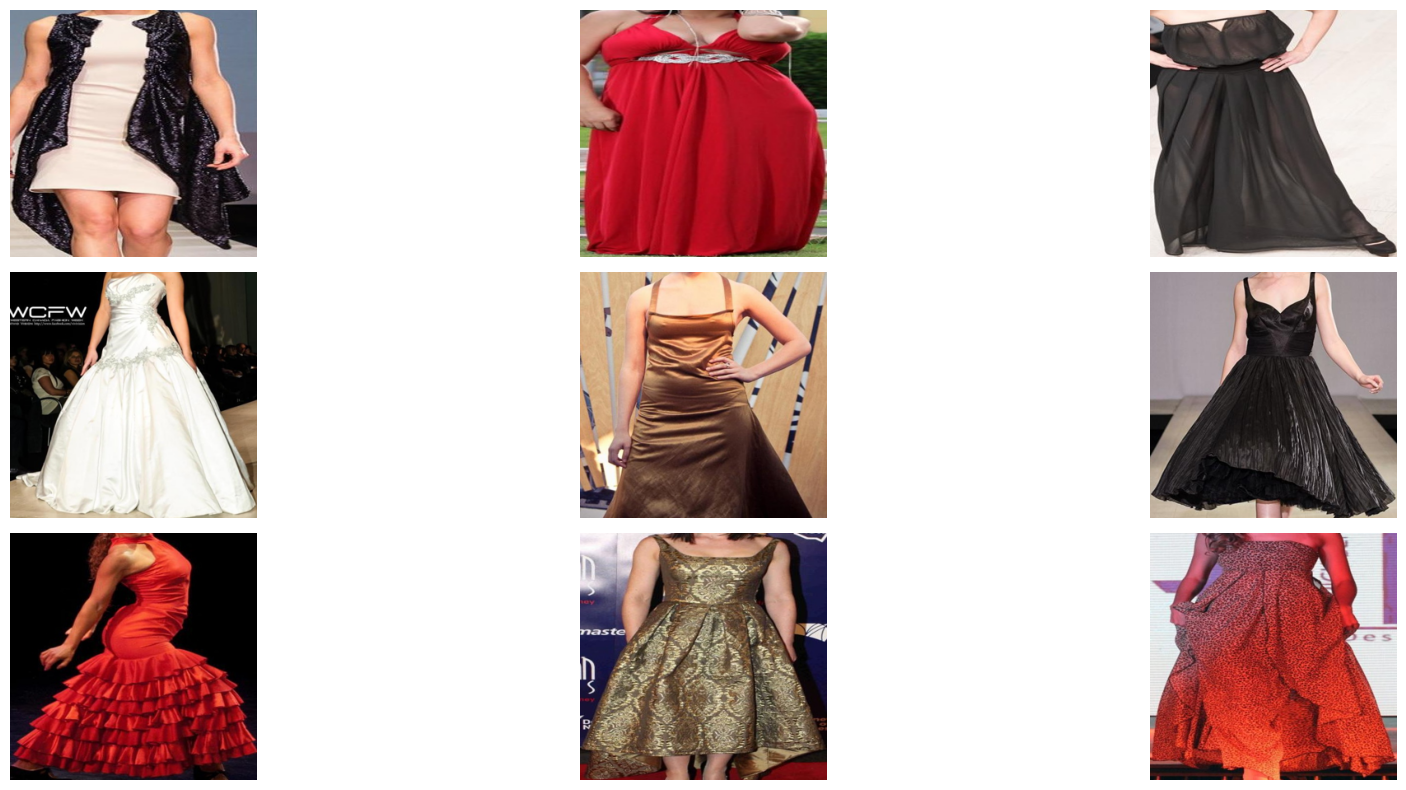

In [44]:
j = 1304

imgss = cv2.imread(df['image_path'][j])
imgss = cv2.cvtColor(imgss,cv2.COLOR_BGR2RGB)
plt.imshow(imgss)
plt.show()

# Assuming `df['caption'][j]` is the long text
long_text = vlm_text(df['image_path'][j])

# Wrap the text to a specified width (e.g., 80 characters per line)
wrapped_text = textwrap.fill(long_text, width=80)

# Print the wrapped text
print(wrapped_text)

inference(model_c,query=long_text, df=df, n_top_images=9)

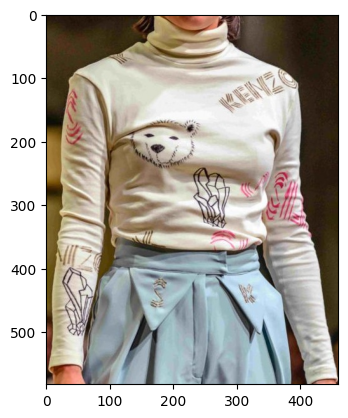

This image features a long-sleeved, unisex top, likely a lightweight knit or
jersey fabric with a smooth, slightly textured surface. The top is a light off-
white color, serving as a backdrop for graphic designs, which include a polar
bear face, crystal-like shapes and the text "KENZO" scattered across the garment
in black and pink lines. The design layout has a whimsical feel and is not
overly structured. The high neck suggests it might be suitable for cooler
weather, such as spring or fall. Paired with the top are light blue, tailored
trousers, possibly made of a smooth satin or similar material, the pants feature
unique triangle detail and embroidered design at the front pockets. The
silhouette of both top and trousers is relatively loose-fitting. Given the
design elements, this outfit is suitable for fashionable casual events or
occasions where unique and artistic style is welcome, with a touch of high-end
design elements. The overall aesthetic leans toward contemporary, and it wou

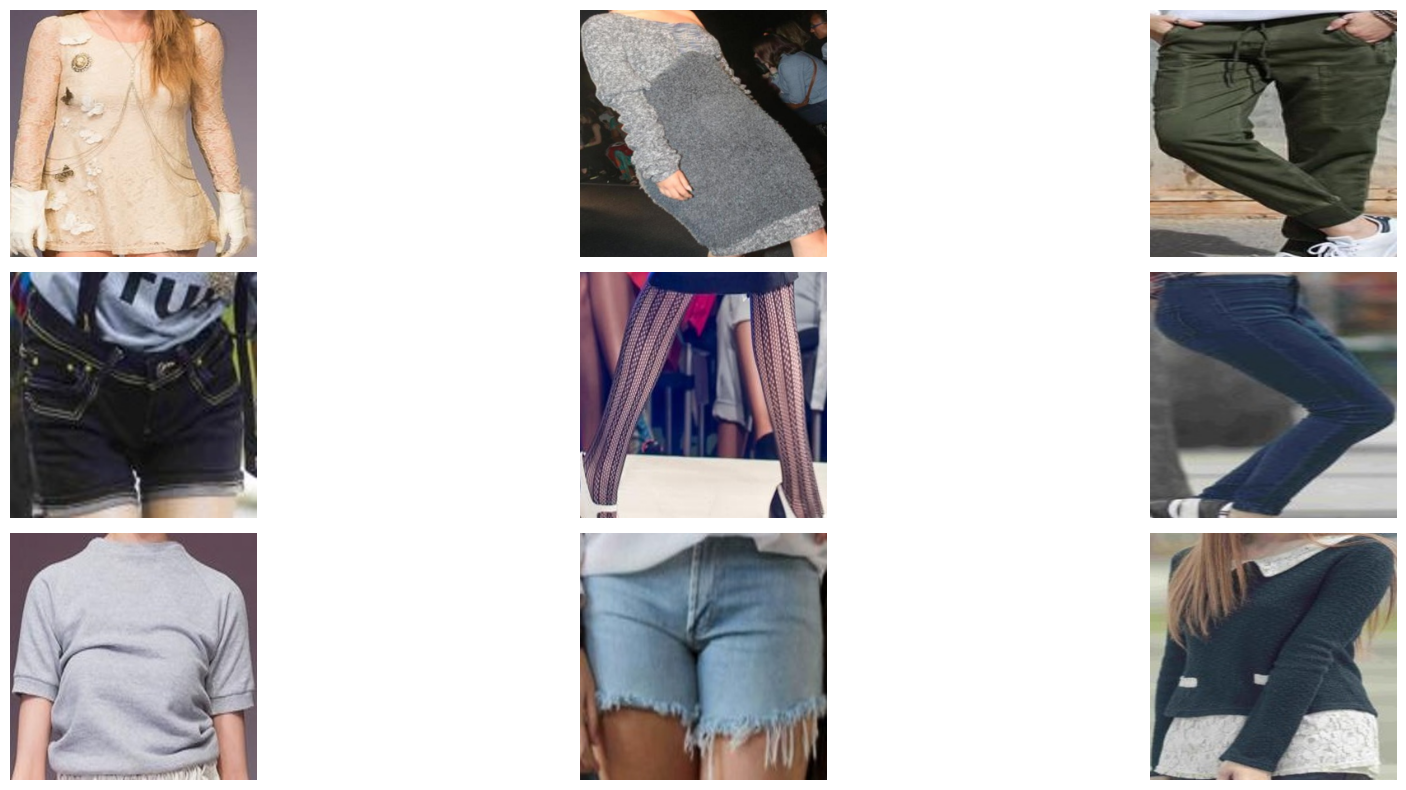

In [52]:
j = 1304

imgss = cv2.imread(df['image_path'][j])
imgss = cv2.cvtColor(imgss,cv2.COLOR_BGR2RGB)
plt.imshow(imgss)
plt.show()

# Assuming `df['caption'][j]` is the long text
long_text = vlm_text(df['image_path'][j])

# Wrap the text to a specified width (e.g., 80 characters per line)
wrapped_text = textwrap.fill(long_text, width=80)

# Print the wrapped text
print(wrapped_text)

inference(model_c,query=long_text, df=df, n_top_images=9)

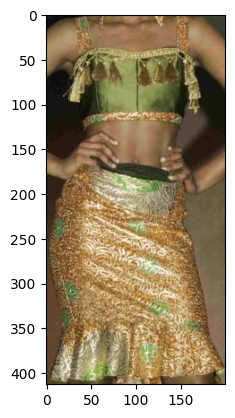

The garment pictured is a two-piece women's outfit consisting of a cropped top
and a midi skirt. The top is a sleeveless, bandeau-style design, fitted and
stopping at the midriff. It is crafted from what appears to be a smooth, olive-
green satin fabric, adorned with golden trim at the top and bottom edges.
Hanging tassels in a tan or bronze color add an ornate touch. The skirt, a
sarong-like piece, has a ruffled hemline and is made from a gold fabric with
intricate, swirling patterns and subtle green accents. The color palette is rich
and earthy, utilizing golds, olive greens, and hints of bronze. Suitable for
warm weather or a semi-formal event, possibly with a cultural theme, the
ensemble has a bohemian, free-spirited feel. The outfit is complemented by
dangling earrings in a gold tone and a dark waistband. The design is slightly
reminiscent of some South Asian-inspired styles.


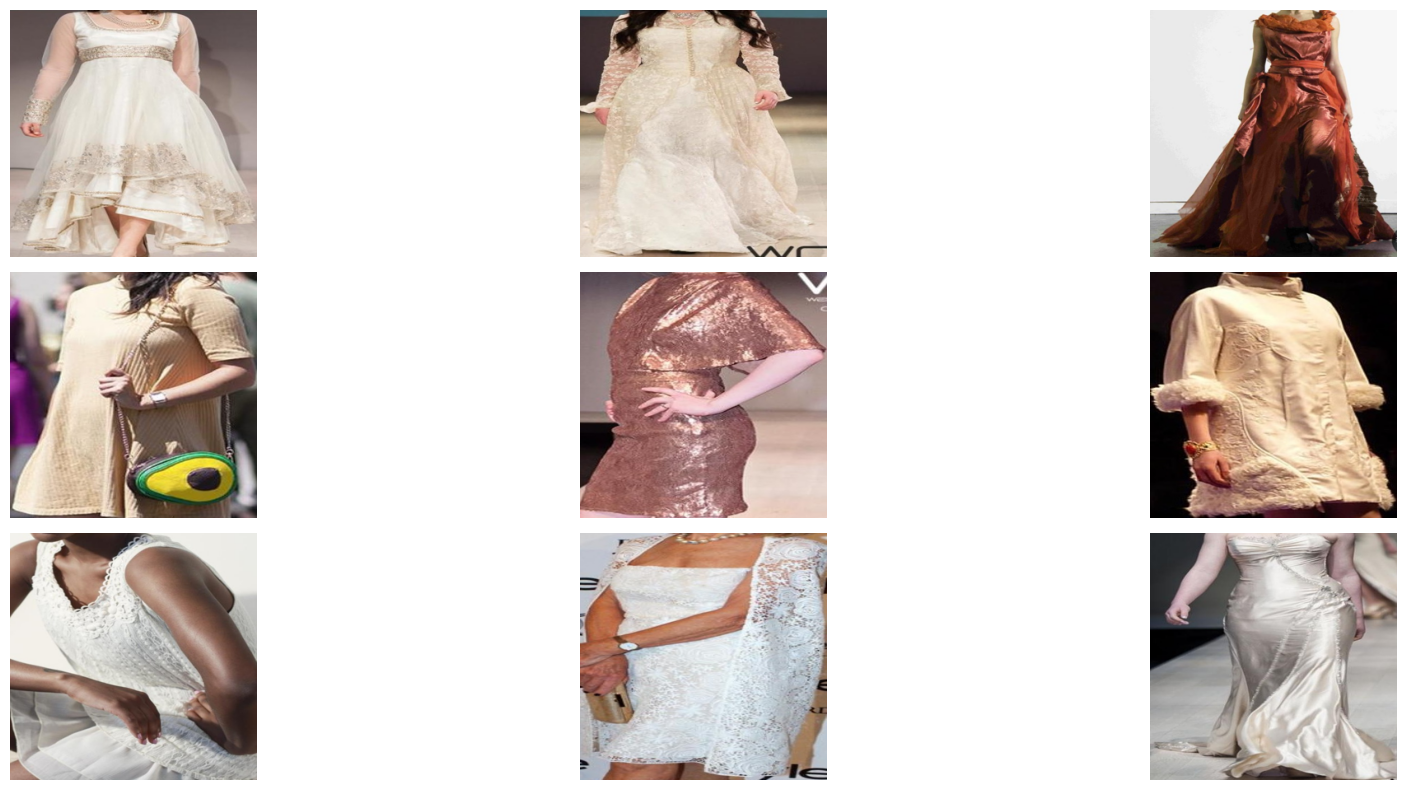

In [54]:
j = 2175

imgss = cv2.imread(df['image_path'][j])
imgss = cv2.cvtColor(imgss,cv2.COLOR_BGR2RGB)
plt.imshow(imgss)
plt.show()

# Assuming `df['caption'][j]` is the long text
long_text = vlm_text(df['image_path'][j])

# Wrap the text to a specified width (e.g., 80 characters per line)
wrapped_text = textwrap.fill(long_text, width=80)

# Print the wrapped text
print(wrapped_text)

inference(model_c,query=long_text, df=df, n_top_images=9)

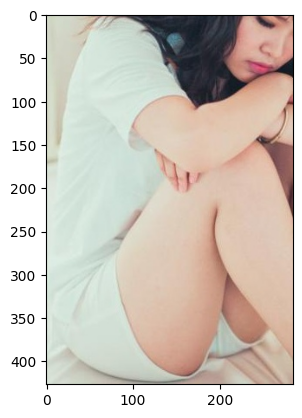

The individual in the image is wearing a simple, white short-sleeved t-shirt,
likely made of a soft, lightweight cotton or cotton-blend material. The garment
appears relaxed and casual, with a basic crew neck and a loose fit, creating a
soft, boxy silhouette.  Given the lack of shaping it can suit both men and women
and is therefore considered unisex. The color scheme is a monochrome white with
no patterns or visible design details.  It's an everyday piece, suited for
casual indoor settings or as a comfortable base layer. The only other visible
accessory is a thin gold bracelet on the wrist. The t-shirt's material and
design make it suitable for warm weather and indoor casual wear and the absence
of embellishments or unusual cuts gives it a minimalist aesthetic and no
cultural or regional styles can be distinguished.


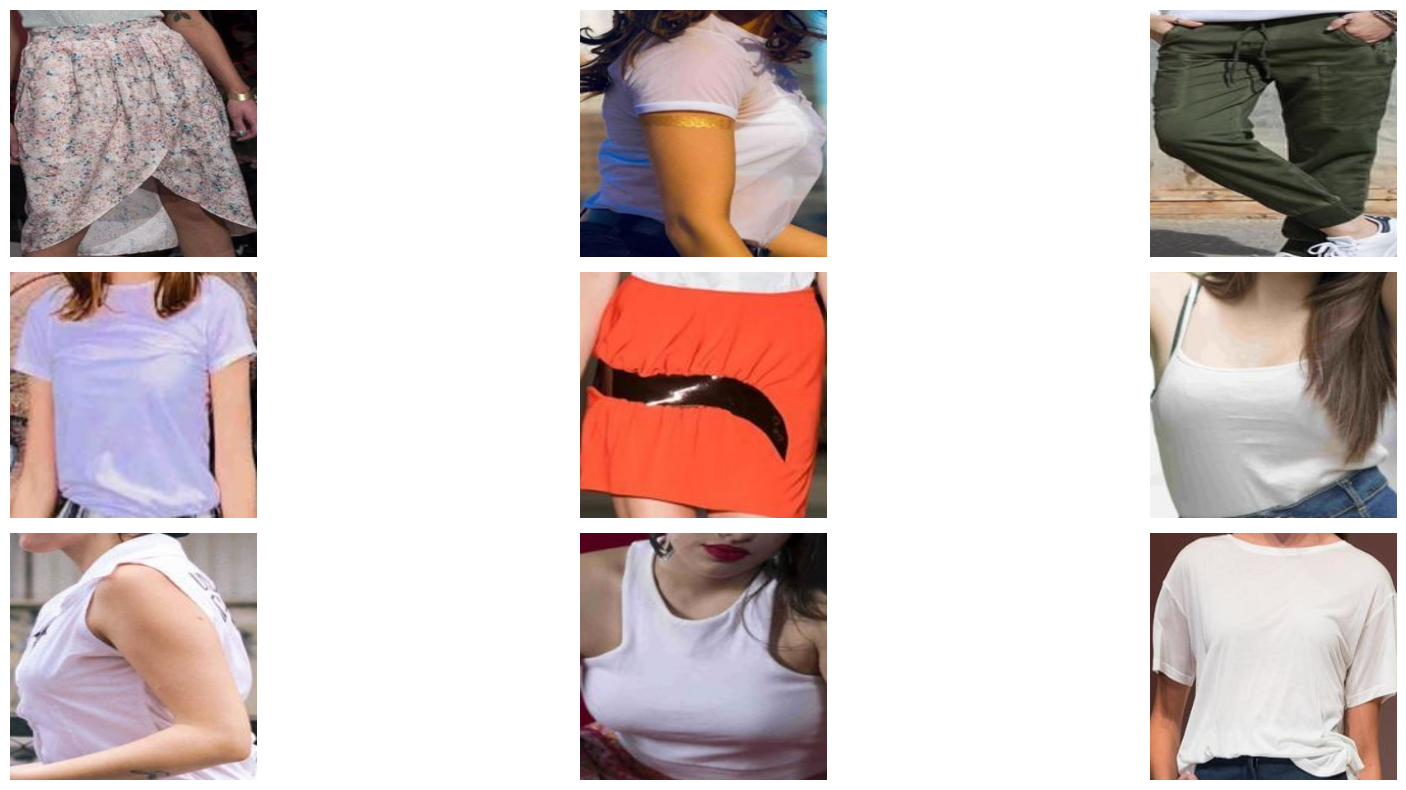

In [ ]:
j = 2175

imgss = cv2.imread(df['image_path'][j])
imgss = cv2.cvtColor(imgss,cv2.COLOR_BGR2RGB)
plt.imshow(imgss)
plt.show()

# Assuming `df['caption'][j]` is the long text
long_text = vlm_text(df['image_path'][j])

# Wrap the text to a specified width (e.g., 80 characters per line)
wrapped_text = textwrap.fill(long_text, width=80)

# Print the wrapped text
print(wrapped_text)

inference(model_c,query=long_text, df=df, n_top_images=9)